In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

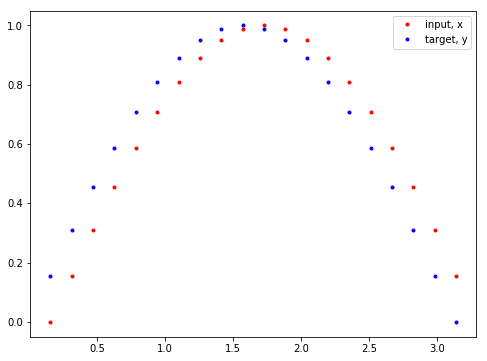

In [2]:
plt.figure(figsize=(8,6));

seq_length = 20

time_steps = np.linspace(0,np.pi,seq_length+1)
data=np.sin(time_steps)

data.resize((seq_length+1,1))

x=data[:-1]
y=data[1:]

plt.plot(time_steps[1:],x,'r.',label='input, x');
plt.plot(time_steps[1:],y,'b.',label='target, y');

plt.legend()
plt.show()

In [3]:
print(x.shape,y.shape)

(20, 1) (20, 1)


This implies we have 20 values in sequence each of input size 1  
And number of output features of RNN we need going to final layer is called hidden_dim   
as we are predicting sine wave next wave given previous value so output_size is 1  
num of hidden layers we consider .. let it be 2 for now

In [7]:
class RNN(nn.Module):
    def __init__(self,input_size,output_size,hidden_dim,n_layers):
        super(RNN,self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.RNN(input_size,hidden_dim,n_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_dim,output_size)
        
    def forward(self,x,hidden):
        batch_size=x.size(0)
        
        r_out,hidden=self.rnn(x,hidden)
        r_out=r_out.view(-1,self.hidden_dim) ## batch_size*seq,hidden_dim
        
        output=self.fc(r_out)
        
        return output,hidden

In [14]:
test_rnn=RNN(input_size=1,output_size=1,hidden_dim=10,n_layers=2)

time_steps = np.linspace(0,np.pi,seq_length)
data=np.sin(time_steps)
data.resize((seq_length,1))

test_input=torch.Tensor(data).unsqueeze(0) 
print("Input size is ",test_input.shape)

test_output,test_h=test_rnn(test_input,None)
print("Output size is ",test_output.shape)
print("Hidden size is ",test_h.shape)

Input size is  torch.Size([1, 20, 1])
Output size is  torch.Size([20, 1])
Hidden size is  torch.Size([2, 1, 10])


Training

In [15]:
input_size=1
output_size=1
hidden_dim=32
n_layers=1

rnn = RNN(input_size,output_size,hidden_dim,n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [16]:
criterion = nn.MSELoss()
optimizer=torch.optim.Adam(rnn.parameters(),lr=0.01)

In [17]:
def train(rnn,n_steps,print_every):
    
    hidden_state=None
    
    for batch_i,step in enumerate(range(n_steps)):
        
        time_steps=np.linspace(step*np.pi,(step+1)*np.pi,seq_length+1)
        data=np.sin(time_steps)
        data.resize(seq_length+1,1)
        
        x=data[:-1]
        y=data[1:]
        
        x_tensor=torch.Tensor(x).unsqueeze(0)
        y_tensor=torch.Tensor(y)
        
        prediction,hidden_state=rnn(x_tensor,hidden_state)
        
        hidden_state=hidden_state.data
        
        optimizer.zero_grad()
        loss=criterion(prediction,y_tensor)
        loss.backward()
        optimizer.step()
        
        if batch_i%print_every==0:
            print("Loss : ",loss.item())
            plt.plot(time_steps[1:],x,'r.')
            plt.plot(time_steps[1:],prediction.data.numpy().flatten(),'b.')
            plt.show()
            
    return rnn
        
        
        

Loss :  0.4707338809967041


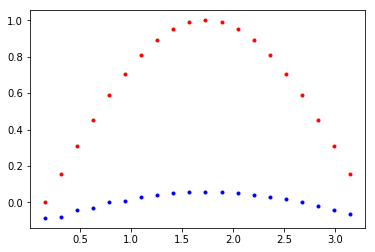

Loss :  0.013324610888957977


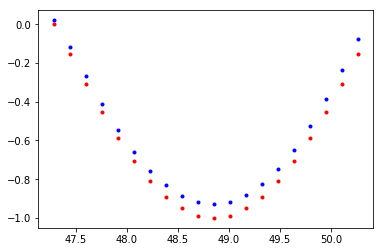

Loss :  0.002807092387229204


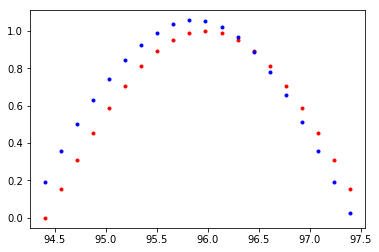

Loss :  0.0007361442549154162


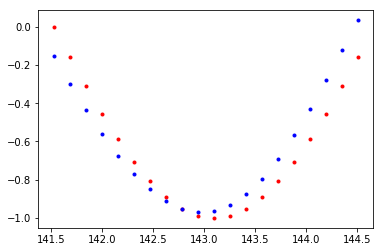

Loss :  0.00010927966650342569


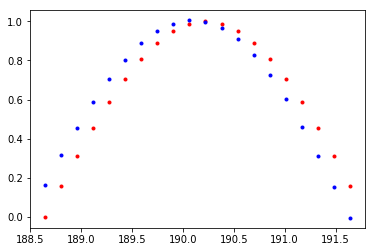

In [18]:
n_steps=75
print_every=15

trained_rnn=train(rnn,n_steps,print_every)